### import python library

In [1]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import sklearn.neighbors
import sklearn
import phenograph
from sklearn.metrics.cluster import adjusted_rand_score
import numpy as np
import random
from copy import deepcopy
import pickle
import os

import seaborn as sns


import argparse
import pandas as pd
import os
import scanpy as sc
from sklearn.metrics.cluster import adjusted_rand_score
# from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import numpy as np
import cv2
import torchvision.transforms as transforms
from utils import Cal_Spatial_Net, Stats_Spatial_Net, seed_everything
# from train_transformer import train_img, test_img

from transModel import TransImg
import torch
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt

from torch_geometric.data import Data

import phenograph
from sklearn.manifold import TSNE
from tqdm import tqdm
import torch.nn.functional as F
import random
import sklearn
import seaborn as sns

### set up Python and R Path

In [2]:
os.environ['R_HOME'] = '/opt/R/4.0.2/lib/R'
os.environ['R_USER'] = '~/anaconda3/lib/python3.8/site-packages/rpy2'
os.environ['LD_LIBRARY_PATH'] = '/opt/R/4.0.2/lib/R/lib'
os.environ['PYTHONHASHSEED'] = '1234'
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'


### generate simulation dataset

#### initailize the domain clusters
1. seed: fix random seed
2. Spatial_cluster: number of domains. Each domain we will assign a dominated cell type
3. Spatial_samples: number of dominated cell

In [5]:
seed=123
spatial_clusters=(0,4)
spatial_samples=1000
np.random.seed(seed)
data = {}
cluster_ids = np.random.randint(spatial_clusters[0], spatial_clusters[1], size=spatial_samples)
data['cell_cluster'] = cluster_ids

#### Assign the cluster ids to the spatial domain. Each cell had its corresponding coordinates
1. gene_feat: the dimension for final gene input
2. img_feat: the dimension for image input
3. gene_latent: the latent dimension for gene expression
4. img_latent: the latent dimension for img

In [13]:
gene_feat=500
img_feat=500
gene_latent=30
img_latent=30

coordinate = np.zeros((cluster_ids.shape[0], 2))
gene_data = np.zeros((cluster_ids.shape[0], gene_feat))
img_data = np.zeros((cluster_ids.shape[0], img_feat))
Z_a = np.zeros([gene_latent, spatial_samples])
Z_b = np.zeros([img_latent, spatial_samples])


In the simulation data, we assume a cell type will dominate a domain layer.
Here we generate the coordinate of the cells/spots to an individual coordinates.

In [14]:
spa_regions = [
        ((10, 240),(10, 240)),
        ((10, 240),(260, 490)),
        ((260,490),(10, 240)),
        ((260,490),(260,490))
]

Z_a = np.zeros([gene_latent, spatial_samples])
Z_b = np.zeros([img_latent, spatial_samples])
mus = []
for spa_clus in list(set(cluster_ids)):
    idx = (cluster_ids == spa_clus)
    range_x, range_y = spa_regions[spa_clus - spatial_clusters[0]]
    sx = np.random.uniform(range_x[0], range_x[1], size=idx.sum())
    sy = np.random.uniform(range_y[0], range_y[1], size=idx.sum())
    coordinate[idx, 0] = sx
    coordinate[idx, 1] = sy        

    cluster_mu1 = np.random.random([gene_latent]) - 0.5
    cluster_mu2 = cluster_mu1
    mus.append((cluster_mu1, cluster_mu2))
    Z_a[:, idx] = np.random.multivariate_normal(mean=cluster_mu1, cov=0.1*np.eye(gene_latent), size=idx.sum()).transpose()
    Z_b[:, idx] = np.random.multivariate_normal(mean=cluster_mu2, cov=0.1*np.eye(img_latent), size=idx.sum()).transpose()
    
data['sx'] = coordinate[:, 0]
data['sy'] = coordinate[:, 1]


Base on the latent dimensions, we add noise and matrix transformation to generate the image inputs and the gene inputs.

In [15]:
def gen_feats(samples, Z, feat, latent, sigma, dropout):
    np.random.seed(123)
    A = np.random.random([feat, latent]) - 0.5
    noise = np.random.normal(0, sigma, size=[feat, samples])
    X = np.dot(A, Z).transpose()
    X[X < 0] = 0
    cutoff = np.exp(-dropout * (X ** 2))
    X = X + noise.T
    X[X < 0] = 0
    Y = deepcopy(X)
    rand_matrix = np.random.random(Y.shape)
    zero_mask = rand_matrix < cutoff
    Y[zero_mask] = 0
    return X, Y

In [18]:
sigma_gene = 0.5
sigma_img = 0.5
dropout_gene = 0.4
dropout_img = 0.4

X_a, Y_a = gen_feats(spatial_samples, Z_a, gene_feat, gene_latent, sigma_gene, dropout_gene)
data['gene_data_full'] = X_a
data['gene_data_dropout'] = Y_a
    
X_b, Y_b = gen_feats(spatial_samples, Z_b, img_feat, img_latent, sigma_img, dropout_img)
data['img_data_full'] = X_b
data['img_data_dropout'] = Y_b

We visualized the four dominated cells. The four colors referred to the four target domains

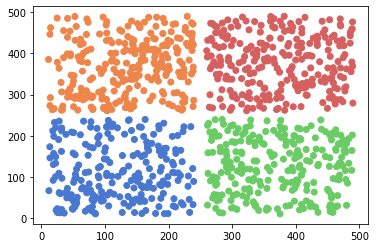

In [19]:
colors = []
my_cmap = sns.color_palette('muted', as_cmap=True)
for cid in cluster_ids:
    colors.append(my_cmap[cid])
plt.scatter(coordinate[:, 0], coordinate[:, 1], c=colors)

### generate the mixsure cells into the spatial profiling.

1. ratio: the ratio of noise cell types in each domain
2. mix_regions: the coordinate range for noise cell types.
3. add_noise_area: the index of mix_region in the spa_regions
4. prior: we assume the mixed cells shared the similar distribution to the dominated cells. For a domain recognition method, the method should detect the four domain layers while each domain may share multiple cells.
4. mu_prior: the mu for each mixing cells

In [25]:
ratio=0.3
mix_regions = [
        ((10, 240), (10, 240)),
        ((10, 240), (10, 240)),
        ((260, 490), (10, 240)),
        ((260, 490), (10, 240)),
        ((10, 240), (260, 490))
]
add_noise_area = [0,0,2,2,1]
prior = [[0, 0.1], [0.1, 0.5], [0, 0.1], [0.1, 0.5], [0.1, 0.1]]

mu_prior = [
    (mus[add_noise_area[i]][0] + prior[i][0], mus[add_noise_area[i]][1] + prior[i][1]) for i in range(len(prior))
]

generate the cluster_id for mixed datasets 
the initialization of mixing cells were same as the dominiate cells, with different nums of samples

In [27]:
mix_cluster = (4,9)
mix_samples = int(ratio * spatial_samples)

np.random.seed(seed)
mix_data = {}

mix_cluster_ids = np.random.randint(mix_cluster[0], mix_cluster[1], size=mix_samples)
mix_data['cell_cluster'] = mix_cluster_ids

simulate the mixing gene expression and the img features.

In [30]:
coordinate = np.zeros((mix_cluster_ids.shape[0], 2))
gene_data = np.zeros((mix_cluster_ids.shape[0], gene_feat))
img_data = np.zeros((mix_cluster_ids.shape[0], img_feat))
    
Z_a = np.zeros([gene_latent, mix_samples])
Z_b = np.zeros([img_latent, mix_samples])
for spa_clus in list(set(mix_cluster_ids)):
    idx = (mix_cluster_ids == spa_clus)
    range_x, range_y = mix_regions[spa_clus - mix_cluster[0]]
    sx = np.random.uniform(range_x[0], range_x[1], size=idx.sum())
    sy = np.random.uniform(range_y[0], range_y[1], size=idx.sum())
    coordinate[idx, 0] = sx
    coordinate[idx, 1] = sy        

    cluster_mu1, cluster_mu2 = mu_prior[spa_clus - mix_cluster[0]]
    Z_a[:, idx] = np.random.multivariate_normal(mean=cluster_mu1, cov=0.1*np.eye(gene_latent), size=idx.sum()).transpose()
    Z_b[:, idx] = np.random.multivariate_normal(mean=cluster_mu2, cov=0.1*np.eye(img_latent), size=idx.sum()).transpose()
    
mix_data['sx'] = coordinate[:, 0]
mix_data['sy'] = coordinate[:, 1]

generate the inputs of mixing data

In [31]:
mix_sigma_gene=0.5
mix_sigma_img=0.5
mix_dropout_gene=0.3
mix_dropout_img=0.3

X_a, Y_a = gen_feats(mix_samples, Z_a, gene_feat, gene_latent, mix_sigma_gene, mix_dropout_gene)
mix_data['gene_data_full'] = X_a
mix_data['gene_data_dropout'] = Y_a
    
X_b, Y_b = gen_feats(mix_samples, Z_b, img_feat, img_latent, mix_sigma_img, mix_dropout_img)
mix_data['img_data_full'] = X_b
mix_data['img_data_dropout'] = Y_b

visualization

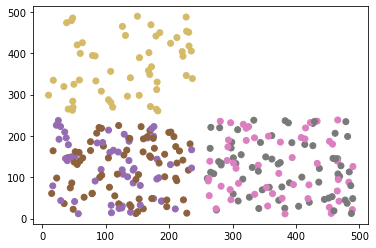

In [34]:
colors = []
my_cmap = sns.color_palette('muted', as_cmap=True)
for cid in mix_cluster_ids:
    colors.append(my_cmap[cid])
plt.scatter(coordinate[:, 0], coordinate[:, 1], c=colors)

Combine the dominating cells and the mixing cells

In [35]:
def combine(spatial_data, mix_data, spatial_regions):
    # assign cluster to mix_data
    combine_data = {}
    
    for k, v in spatial_data.items():
        v2 = mix_data[k]
        v3 = np.concatenate([v, v2])
        combine_data[k] = v3
    
    combine_data['domain_cluster'] = []
    for (sx, sy) in zip(combine_data['sx'], combine_data['sy']):
        for idx, (rx, ry) in enumerate(spatial_regions):
            if sx >= rx[0] and sx <= rx[1] and sy >= ry[0] and sy <= ry[1]:
                combine_data['domain_cluster'].append(idx)
    
    return combine_data

In [36]:
combine_data = combine(data, mix_data, spa_regions)

Visualize the combine data

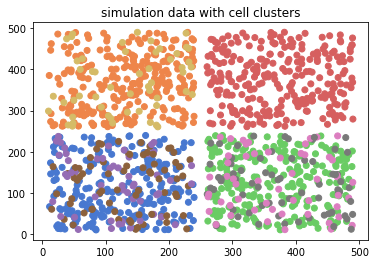

In [56]:
colors = []
my_cmap = sns.color_palette('muted', as_cmap=True)
for cid in combine_data['cell_cluster']:
    colors.append(my_cmap[cid])
plt.title("simulation data with cell clusters")
plt.scatter(combine_data['sx'], combine_data['sy'], c=colors)


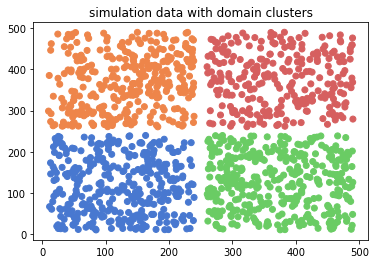

In [55]:
colors = []
my_cmap = sns.color_palette('muted', as_cmap=True)
for cid in combine_data['domain_cluster']:
    colors.append(my_cmap[cid])
plt.title("simulation data with domain clusters")
plt.scatter(combine_data['sx'], combine_data['sy'], c=colors)


save the generated simulation data

In [53]:
def save_data_pickle(data, save_name):
    with open(save_name, 'wb') as f:
        pickle.dump(data, f)

if not os.path.exists('simulation'):
    os.mkdir('simulation')
if not os.path.exists('simulation_results'):
    os.mkdir('simulation_results')       
        
save_name = 'simulation/jupyter_demo.pkl'
save_data_pickle(combine_data, save_name)

run pca for the simulated data

In [45]:
def run_pca(root_dir, name, label_type='domain_cluster', save_path='simulation_results/1.csv'):
    pkl_file = os.path.join(root_dir, name+'.pkl')
    csv_file = os.path.join(root_dir, name+'.csv')
    adata_file = os.path.join(root_dir, name+'.h5ad')
    with open(pkl_file, 'rb') as f:
        data = pickle.load(f)
    
    data_a = data['gene_data_dropout']
    data_b = data['img_data_dropout']
    label_true = data[label_type]
    
    df = pd.DataFrame()
    df['label_domain'] = data['domain_cluster']
    df['label_cell'] = data['cell_cluster']
    
    gene_feat = PCA(n_components=30).fit_transform(data_a)
    img_feat = PCA(n_components=30).fit_transform(data_b)
    
    feat_df = pd.DataFrame(gene_feat)
    feat_df.to_csv('simulation_results/gene_emb_%s.csv'%(str(name)))
    
    feat_df = pd.DataFrame(img_feat)
    feat_df.to_csv('simulation_results/img_emb_%s.csv'%(str(name)))
    
    my_cmap = sns.color_palette('muted', as_cmap=True)
    colors = []
    for cid in data['domain_cluster']:
        colors.append(my_cmap[cid])
    size = 10
     # gene
    pred1, _, _ = phenograph.cluster(gene_feat)
    plt.figure(figsize=(17, 5))
    plt.subplot(1, 3, 1)
    X_embedded = TSNE(n_components=2).fit_transform(gene_feat)
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=colors, s=size)
    plt.title('gene, ARI = %01.3f' % adjusted_rand_score(label_true, pred1))

    pred2, _, _ = phenograph.cluster(img_feat)

    plt.subplot(1, 3, 2)
    X_embedded = TSNE(n_components=2).fit_transform(img_feat)
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=colors, s=size)
    plt.title('img, ARI = %01.3f' % adjusted_rand_score(label_true, pred2))


    df['gene_pca'] = pred1
    df['img_pca'] = pred2
    df.to_csv(save_path)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.36939430236816406 seconds
Jaccard graph constructed in 0.9088349342346191 seconds
Wrote graph to binary file in 0.06199502944946289 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.590286
After 2 runs, maximum modularity is Q = 0.592366
After 5 runs, maximum modularity is Q = 0.594879
Louvain completed 25 runs in 1.2841527462005615 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 3.0830421447753906 seconds


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.44403672218322754 seconds
Jaccard graph constructed in 1.087918996810913 seconds
Wrote graph to binary file in 0.049889564514160156 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.637958
After 2 runs, maximum modularity is Q = 0.641351
After 19 runs, maximum modularity is Q = 0.642642
After 34 runs, maximum modularity is Q = 0.643958
Louvain completed 54 runs in 2.586662769317627 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 4.57122802734375 seconds


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


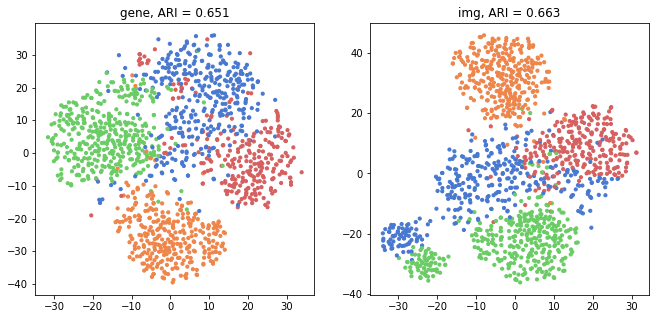

In [57]:
csv_save = 'simulation_results/jupyter_demo.csv'
run_pca('simulation/', 'jupyter_demo', label_type='domain_cluster', save_path=csv_save)

run sigra and save the embedings and predictions

In [58]:
from simulate_sigra import run_sigra_model

In [60]:
sigra_pred, sigra_emb = run_sigra_model('simulation/', 'jupyter_demo', n_epochs=800, hidden_dims=[512, 30], seed=seed, lambda_1=0.5, lambda_2=0.5, lambda_3=1.0, graph_type='spatial', gt_type='domain')

jupyter_demo
Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.4427626132965088 seconds
Jaccard graph constructed in 1.0942184925079346 seconds
Wrote graph to binary file in 0.048673391342163086 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.401385
After 11 runs, maximum modularity is Q = 0.402794
Louvain completed 31 runs in 1.5043220520019531 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 3.4684016704559326 seconds
Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.4450957775115967 seconds
Jaccard graph constructed in 1.0642950534820557 seconds
Wrote graph to binary file in 0.0437321662902832 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.414514
After 2 runs, maximum modularity is Q = 0.416757
After 3 runs, maximum modularity is Q = 0.427928
After 5 runs, maximum modularity is Q

100%|███████████████████████████████████████████████| 800/800 [00:59<00:00, 13.48it/s]


Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.6906263828277588 seconds
Jaccard graph constructed in 1.6464486122131348 seconds
Wrote graph to binary file in 0.05511760711669922 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.652592
After 3 runs, maximum modularity is Q = 0.654
After 5 runs, maximum modularity is Q = 0.656289
Louvain completed 25 runs in 2.9438843727111816 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 6.01379656791687 seconds
jupyter_demo 0.8471


calculating the ari

In [69]:
from simulate_sigra import save_method_pred
emb_df = pd.DataFrame(sigra_emb)
emb_df.to_csv('simulation_results/sigra_emb_spatial_jupyter_demo.csv')
save_method_pred('simulation_results/jupyter_demo.csv', sigra_pred, 'sigra')

In [70]:
from sklearn.metrics.cluster import adjusted_rand_score
csv = pd.read_csv('simulation_results/jupyter_demo.csv', header=0, index_col=0)
print(csv)

      label_domain  label_cell  gene_pca  img_pca  sigra
0                2           2         2        0      0
1                1           1         1        1      2
2                2           2         4        0      0
3                2           2         2        0      0
4                0           0         3        2      1
...            ...         ...       ...      ...    ...
1295             0           4         0        2      1
1296             0           5         0        4      1
1297             1           8         1        0      2
1298             2           7         2        4      0
1299             2           6         2        0      0

[1300 rows x 5 columns]


In [71]:
ari = adjusted_rand_score(csv['label_domain'], csv['sigra'])
print("ari: %.2f"%(ari))

ari: 0.85
